[*********************100%***********************]  5 of 5 completed


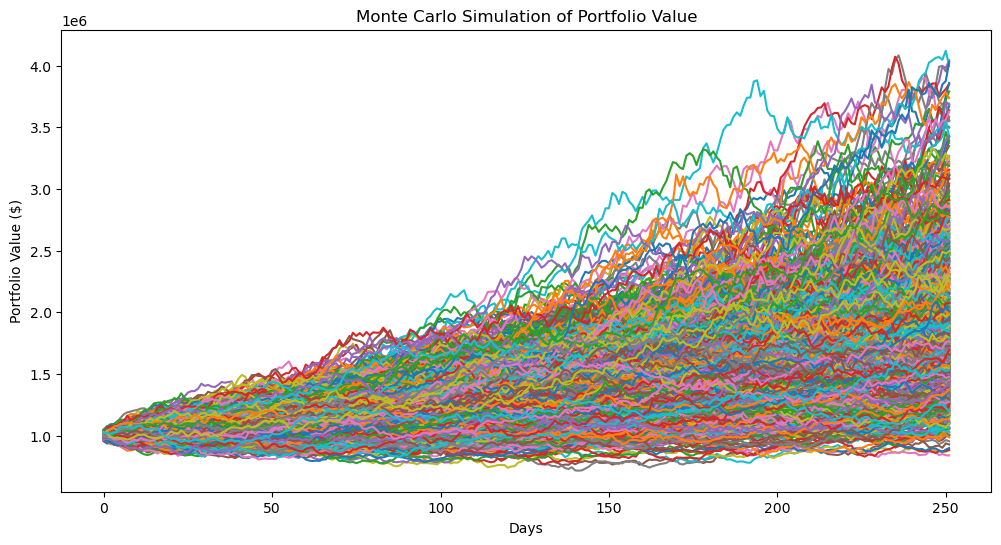

Value at Risk (VaR) Results:
99.0% VaR: $-8,849.25
95.0% VaR: $-181,261.34
90.0% VaR: $-288,837.72


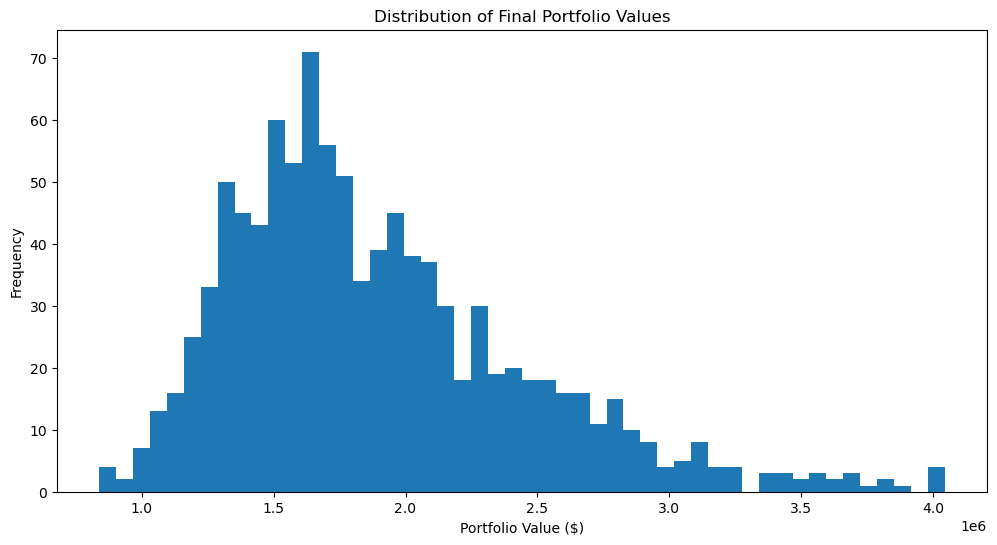


Portfolio Statistics:
Expected Value: $1,891,038.50
Standard Deviation: $560,956.26


In [5]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

# Define the stocks and portfolio weights
stocks = ['AAPL', 'MSFT', 'META', 'GOOGL', 'NVDA']
weights = np.array([0.2, 0.2, 0.2, 0.2, 0.2])  # Equal weights for simplicity

# Download historical data
data = yf.download(stocks, start="2023-11-08", end="2024-11-08")['Adj Close']

# Calculate log returns
log_returns = np.log(data / data.shift(1)).dropna()

# Calculate parameters
mu = log_returns.mean().values
cov_matrix = log_returns.cov().values

# Simulation parameters
num_simulations = 1000
time_horizon = 252  # One trading year
initial_portfolio_value = 1000000  # $1 million initial investment

# Simulation
np.random.seed(42)
Z = np.random.normal(size=(num_simulations, time_horizon, len(stocks)))
L = np.linalg.cholesky(cov_matrix)

# Correctly reshape mu and perform the calculation
daily_returns = mu.reshape(1, 1, -1) + np.einsum('ij,klj->kli', L, Z)
price_paths = np.exp(np.cumsum(daily_returns, axis=1))

# Calculate portfolio values
portfolio_values = np.sum(price_paths * weights, axis=2) * initial_portfolio_value

# Calculate VaR
confidence_levels = [0.99, 0.95, 0.90]
var_values = {}

for confidence in confidence_levels:
    var_values[confidence] = np.percentile(portfolio_values[:, -1] - initial_portfolio_value, 100 - confidence * 100)

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(portfolio_values.T)
plt.title('Monte Carlo Simulation of Portfolio Value')
plt.xlabel('Days')
plt.ylabel('Portfolio Value ($)')
plt.show()

# Print results
print("Value at Risk (VaR) Results:")
for confidence, var in var_values.items():
    print(f"{confidence*100}% VaR: ${-var:,.2f}")

# Histogram of final portfolio values
plt.figure(figsize=(12, 6))
plt.hist(portfolio_values[:, -1], bins=50)
plt.title('Distribution of Final Portfolio Values')
plt.xlabel('Portfolio Value ($)')
plt.ylabel('Frequency')
plt.show()

# Print additional statistics
print("\nPortfolio Statistics:")
print(f"Expected Value: ${np.mean(portfolio_values[:, -1]):,.2f}")
print(f"Standard Deviation: ${np.std(portfolio_values[:, -1]):,.2f}")
